# 6. Correlation Analysis for Salary Prediction in PySpark

In this notebook, I conducted correlation analysis to explore the relationships between features and both maximum and minimum salaries. This analysis aimed to identify significant features relevant to the task of predicting salaries.

## Notebook Overview:
- Importing Required Resources: This stage involves importing all necessary resources, including PySpark, to facilitate subsequent stages of the project. Additionally, Java installation is required to execute this notebook.
  
- Loading Data: The dataset "processed_job_descriptions.csv," which was processed previously, will be loaded to initiate data exploration and further processing using PySpark functionalities.

- Data Type Conversion and Encoding: Various data types such as date and string need to be converted into numerical data. Therefore, appropriate conversion methods and encoding techniques will be applied to these features.

- Correlation Analysis: To assess the strength and importance of features concerning minimum and maximum salaries, correlation analysis will be conducted. This step aims to understand the relationships between different features and salary ranges.

- Removing Unnecessary Features: Based on the correlation analysis results, features deemed less important will be removed from the dataset. This step enhances the quality of the data by focusing on relevant features for salary prediction.

- Saving the Processed Data: Upon completion of all preprocessing steps, if we remove any feature then the new DataFrame will be saved as "processed_job_descriptions_2" for subsequent model training and prediction tasks, otherwise not. 

### Importing Required Resources

In [5]:
import findspark

findspark.init()

from pyspark.sql import SparkSession 
spark = SparkSession.builder.appName('Name').config('config_option', 'value').getOrCreate()

import warnings

warnings.filterwarnings("ignore")

from pyspark.sql.functions import col, unix_timestamp
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Data Loading and Visualization 

In [6]:
df = spark.read.option('inferSchema', True).csv('processed_job_descriptions.csv', header=True)
df.limit(1).toPandas()

,Qualifications,location,Country,latitude,longitude,Work Type,Company Size,Job Posting Date,Preference,Job Title,...,Job Description,Benefits,skills,Responsibilities,Company,Company Profile,Min Salary,Max Salary,Min Exp,Max Exp
0,M.Tech,Douglas,Isle of Man,54.2361,-4.5481,Intern,26801,2022-04-24,Female,Digital Marketing Specialist,...,Social Media Managers oversee an organizations...,"{'Flexible Spending Accounts (FSAs), Relocatio...","Social media platforms (e.g., Facebook, Twitte...","Manage and grow social media accounts, create ...",Icahn Enterprises,"""{""""Sector"""":""""Diversified""""",59000,99000,5,15


### Data Type Conversion and Encoding

In [7]:
# Convert 'Job Posting Date' to Unix timestamp
df = df.withColumn('Job Posting Date', unix_timestamp('Job Posting Date').cast('double'))

# Define the columns of interest
selected_columns = [col for col in df.columns if col not in ['Min Salary', 'Max Salary']]

# Separate string, numeric, and date columns
string_columns = [col for col in selected_columns if df.select(col).dtypes[0][1] == 'string']
numeric_columns = [col for col in selected_columns if col not in string_columns and col != 'Job Posting Date']
date_column = ['Job Posting Date']

# StringIndexer and OneHotEncoder for string columns
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid='keep') for col in string_columns]
encoders = [OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_encoded") for col in string_columns]

# Assemble all features
assembler = VectorAssembler(inputCols=numeric_columns + [f"{col}_encoded" for col in string_columns] + date_column, outputCol="features")

# Apply transformations using a Pipeline
pipeline_stages = indexers + encoders + [assembler]
pipeline = Pipeline(stages=pipeline_stages)
transformed_df = pipeline.fit(df).transform(df).select("features", "Min Salary", "Max Salary")

# Show transformed data
transformed_df.show()

+--------------------+----------+----------+
|            features|Min Salary|Max Salary|
+--------------------+----------+----------+
|(3223,[0,1,2,3,4,...|     59000|     99000|
|(3223,[0,1,2,3,4,...|     56000|    116000|
|(3223,[0,1,2,4,9,...|     61000|    104000|
|(3223,[0,1,2,3,4,...|     65000|     91000|
|(3223,[0,1,2,3,4,...|     64000|     87000|
|(3223,[0,1,2,3,4,...|     59000|     93000|
|(3223,[0,1,2,3,4,...|     63000|    103000|
|(3223,[0,1,2,3,4,...|     65000|    102000|
|(3223,[0,1,2,3,4,...|     65000|    102000|
|(3223,[0,1,2,3,4,...|     60000|     80000|
|(3223,[0,1,2,3,4,...|     57000|    104000|
|(3223,[0,1,2,3,4,...|     64000|     98000|
|(3223,[0,1,2,3,4,...|     65000|    122000|
|(3223,[0,1,2,3,4,...|     56000|     86000|
|(3223,[0,1,2,3,4,...|     57000|     98000|
|(3223,[0,1,2,3,4,...|     65000|    100000|
|(3223,[0,1,2,3,4,...|     60000|     83000|
|(3223,[0,1,2,4,6,...|     55000|    117000|
|(3223,[0,1,2,3,4,...|     55000|    121000|
|(3223,[0,

### Correlation Analysis

In [8]:
# Calculate the correlation matrix
correlation_matrix = Correlation.corr(transformed_df, "features").head()

In [9]:
# Extract the correlation values for 'Max Salary' with other features
max_salary_correlation = correlation_matrix[0].toArray()[0]

# Print the correlation values
print("Correlation of Max Salary with other features:")
min_length = min(len(selected_columns), len(max_salary_correlation) - 1)
for i in range(min_length):
    print(f"{selected_columns[i]}: {max_salary_correlation[i+1]}")


Correlation of Max Salary with other features:
Qualifications: 0.02175269923059981
location: 0.00014933652809700102
Country: -0.0005074696648560646
latitude: 0.001038571146846713
longitude: -0.0005886876362814141
Work Type: -0.000160136033486164
Company Size: 6.525796868589047e-05
Job Posting Date: 0.0005003473953353723
Preference: -0.0003462095536812206
Job Title: -9.69732181683028e-07
Role: 3.895949263316717e-05
Job Portal: -0.00030722764183763434
Job Description: 0.0010200074334243585
Benefits: -0.00022010043548302273
skills: 0.07737866743428938
Responsibilities: -0.13747859793845582
Company: 0.0487152297161376
Company Profile: -0.03803411418723048
Min Exp: -0.04175440781930994
Max Exp: -0.03197408416462315


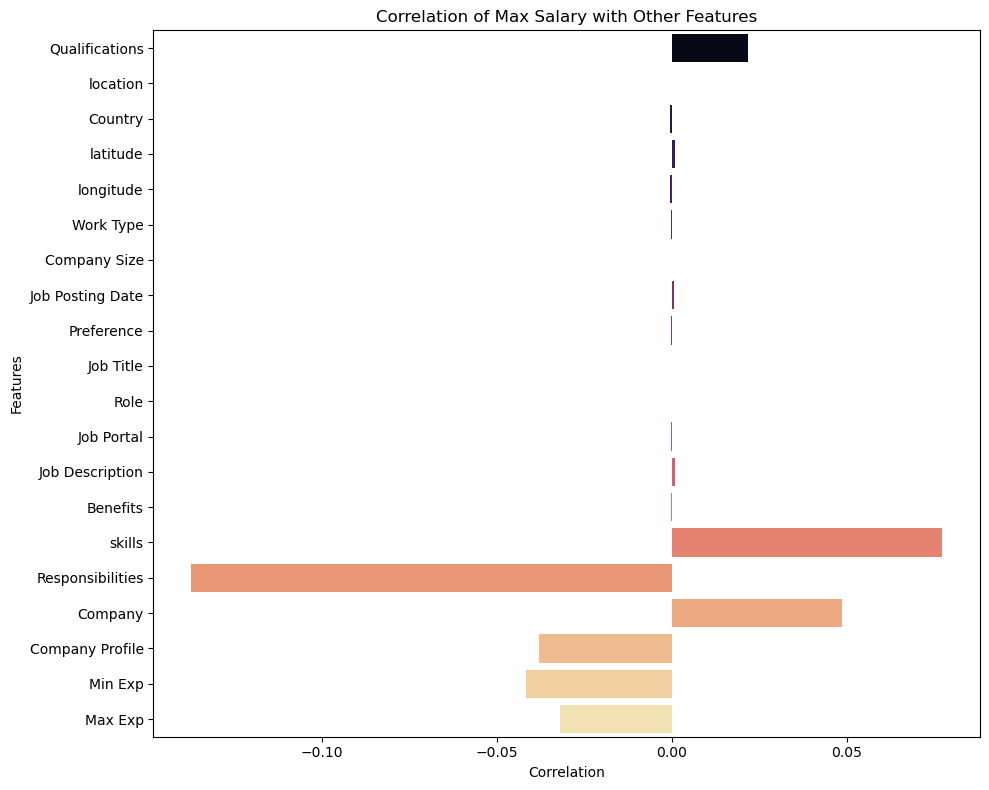

In [10]:
correlation_values = {
    'Qualifications': 0.02175269923059978,
    'location': 0.00014933652809700102,
    'Country': -0.0005074696648560646,
    'latitude': 0.001038571146846713,
    'longitude': -0.0005886876362813828,
    'Work Type': -0.00016013603348622674,
    'Company Size': 6.525796868595327e-05,
    'Job Posting Date': 0.0005003473953354352,
    'Preference': -0.00034620955368128343,
    'Job Title': -9.697321817458773e-07,
    'Role': 3.895949263316717e-05,
    'Job Portal': -0.0003072276418376972,
    'Job Description': 0.001020007433424327,
    'Benefits': -0.00022010043548302273,
    'skills': 0.07737866743428935,
    'Responsibilities': -0.13747859793845582,
    'Company': 0.0487152297161376,
    'Company Profile': -0.03803411418723048,
    'Min Exp': -0.04175440781930994,
    'Max Exp': -0.03197408416462315
}

# Convert correlation values dictionary to a DataFrame for plotting
correlation_df = pd.DataFrame.from_dict(correlation_values, orient='index', columns=['Correlation'])

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x=correlation_df['Correlation'], y=correlation_df.index, palette='magma')
plt.title('Correlation of Max Salary with Other Features')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('correlation_max.png')
plt.show()

In [11]:
# Extract the correlation values for 'Min Salary' with other features
min_salary_correlation = correlation_matrix[0].toArray()[-1]

# Print the correlation values
print("Correlation of Min Salary with other features:")
min_length = min(len(selected_columns), len(min_salary_correlation) - 1)
for i in range(min_length):
    print(f"{selected_columns[i]}: {min_salary_correlation[i+1]}")

Correlation of Min Salary with other features:
Qualifications: 0.0008806300403436123
location: 0.001263795669450524
Country: 0.0004950743576108863
latitude: 0.00033398185453117657
longitude: -0.0003837380347917482
Work Type: 0.0003360291236764729
Company Size: -0.0007499760999557624
Job Posting Date: -0.00031150851443163845
Preference: -0.0003726197802057365
Job Title: 0.0018272340197699388
Role: -0.00044120020831811947
Job Portal: -0.0002144131226755504
Job Description: -0.00012550851052307925
Benefits: 0.0004370068573946226
skills: -9.167598517536806e-05
Responsibilities: 0.0005445259803041701
Company: -0.0005320987776705496
Company Profile: 0.0003957702263409025
Min Exp: 7.161263885049809e-05
Max Exp: 0.0007565341132901958


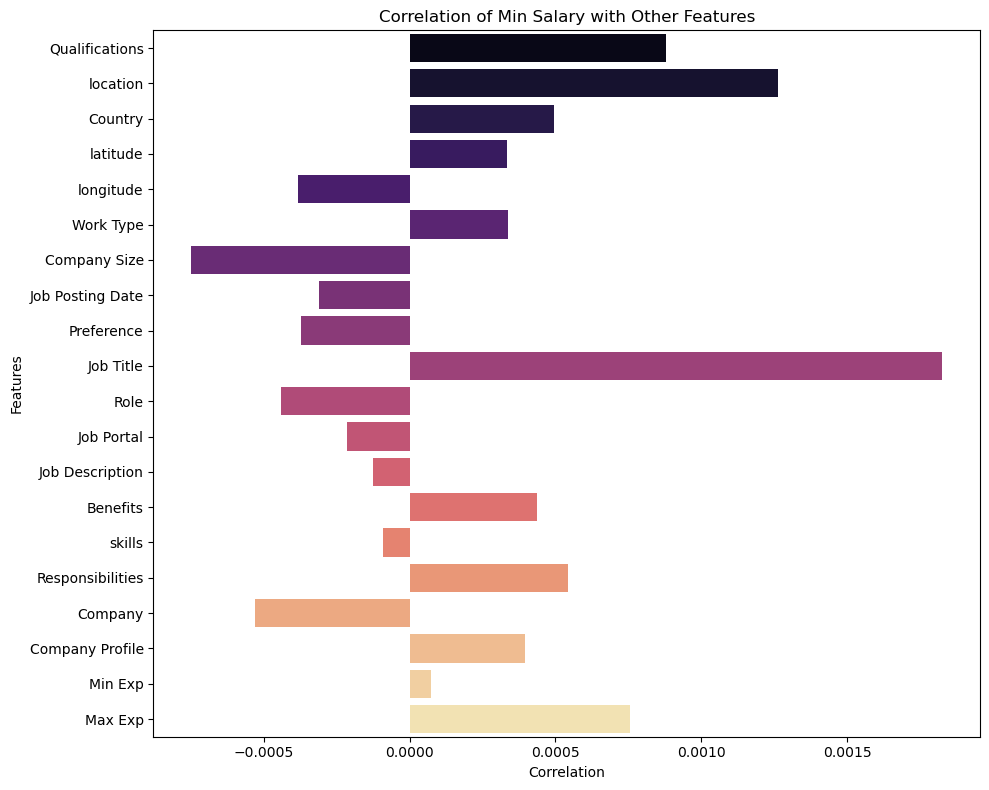

In [13]:
# Define the correlation values for Min Salary
min_salary_correlation_values = {
    'Qualifications': 0.0008806300403442897,
    'location': 0.0012637956694514963,
    'Country': 0.0004950743576112673,
    'latitude': 0.0003339818545314336,
    'longitude': -0.0003837380347920434,
    'Work Type': 0.00033602912367673135,
    'Company Size': -0.0007499760999563393,
    'Job Posting Date': -0.0003115085144318781,
    'Preference': -0.00037261978020602314,
    'Job Title': 0.0018272340197713443,
    'Role': -0.000441200208318459,
    'Job Portal': -0.00021441312267571537,
    'Job Description': -0.0001255085105231758,
    'Benefits': 0.0004370068573949589,
    'skills': -9.167598517543859e-05,
    'Responsibilities': 0.000544525980304589,
    'Company': -0.000532098777670959,
    'Company Profile': 0.00039577022634120694,
    'Min Exp': 7.161263885055319e-05,
    'Max Exp': 0.0007565341132907779
}

# Convert correlation values dictionary to a DataFrame for plotting
min_salary_correlation_df = pd.DataFrame.from_dict(min_salary_correlation_values, orient='index', columns=['Correlation'])

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x=min_salary_correlation_df['Correlation'], y=min_salary_correlation_df.index, palette='magma')
plt.title('Correlation of Min Salary with Other Features')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('correlation_min.png')
plt.show()

### Removing Unnecessary Features

Within this dataset, I've observed that all features exhibit a degree of correlation with our target variables, albeit in markedly distinct ways for maximum and minimum salaries. Minimum salary appears to be primarily correlated with job title and location, whereas maximum salary shows strong correlation with responsibilities and skills. While minimum salary displays some level of correlation with nearly all features, the correlation for maximum salary is negligible for most features, except for a select few.

This differentiation is reasonable, as minimum salary often varies based on factors like geographical location and job type, while maximum salary is predominantly influenced by the level of responsibilities and skills possessed. Given that there isn't a single feature that demonstrates zero correlation with both target variables, I have decided against removing any features based solely on their lack of correlation with the target variable.

### Saving the Processed Data

Given that we haven't excluded any features post correlation analysis and CSV doesn't accommodate complex data types like encoded or vectorized data, we won't proceed with saving the file at this point.